In [ ]:
#!pip install pandas
#!pip install matplotlib
#!pip install statsmodels
#!pip install scikit-learn
#!pip install seaborn
#!pip install timeeval
#pip install matplotlib, statsmodels, scikit-learn, seaborn, timeeval

In [2]:
from pathlib import Path
import sys
# Agregar el path del directorio "code"
code_path = Path("../code").resolve()
if str(code_path) not in sys.path:
    sys.path.insert(0, str(code_path))



In [3]:

import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
from utils import get_channel
from CustomTransformers import TimeSeriesFreqRegularization
from utils import rolling_forecast
mission_name = 'ESA-Mission1'
channel_name = "channel_44"
channel = get_channel(mission_name, channel_name)

In [4]:
df = channel["data"]

In [5]:
#df = df.asfreq(pd.infer_freq(df.index))

Si tomo muchos datos me da que la serie es estacionaria, pero...tiene estacionalidad no contemplada y eso parece ser un problema, por tanto tomo una cantidad de datos pequeños

Regularizo la serie de tiempos :(

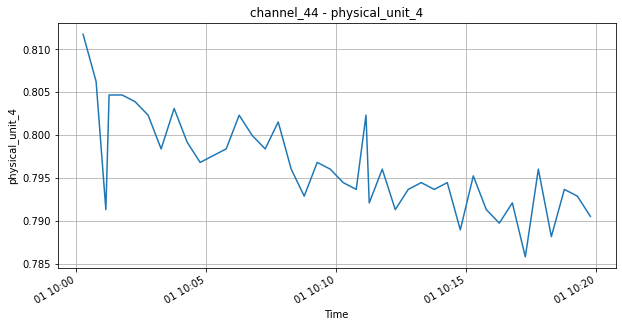

In [6]:
dt_from = '2000-01-01 10:00:00'
dt_to   = '2000-01-01 10:20:00'
ldf = df[(df.index >= dt_from) & (df.index <= dt_to)]
plt.figure(figsize=(10, 5))
plt.plot(ldf.index, ldf[channel_name], label=channel["Channel"])
plt.title(channel["Channel"] + " - " + channel["Physical Unit"])
plt.xlabel("Time")      
plt.ylabel(channel["Physical Unit"])
#plt.set_major_locator(mdates.DayLocator(interval=7))  # cada 7 días
plt.gcf().autofmt_xdate()  # Ajusta las fechas automáticamente
plt.grid()
plt.show()


In [7]:
tsr = TimeSeriesFreqRegularization(columns=[channel_name])
tsr.fit(ldf)
print(f"Frecuencia: {tsr.most_frequent_frequency_}s")
ldf = tsr.transform(ldf)

Frecuencia: 30s


## Primera pregunta. ¿Es estacionaria la serie?
### Aplicamos ADF

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(ldf[channel_name])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.6286179139614005
p-value: 0.46821423489132036


No rechazamos la hipótesis nula de que la serie tiene una raíz unitaria y por tanto no es estacionaria. Debemos obtener la diferencia de primer orden. 

In [9]:
ldf.loc[:,['values_diff']] = ldf[channel_name].diff()
df_diff1 = ldf.copy()
df_diff1.dropna(inplace=True)

Dibujamos valores y diferencia orden 1

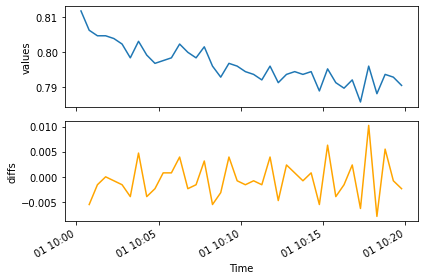

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(ldf[channel_name])
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
#ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(ldf['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
#ax2.axvspan(449, 498, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()
plt.show()

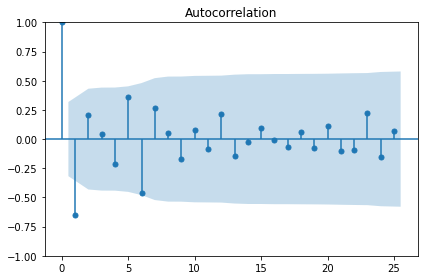

In [11]:
#El primer elemento es NaN, por eso no lo consideramos
plot_acf(df_diff1.iloc[1:]["values_diff"], lags=25)
plt.tight_layout()
plt.show()
#MA(22)?

¿Es un random walk? => No, es un moving average de 1

In [12]:
#Perdemos el primero
df_diff1.dropna(inplace=True)
df_diff1

,channel_44,values_diff
2000-01-01 10:00:46.353,0.806262,-0.005510
2000-01-01 10:01:16.353,0.804688,-0.001575
2000-01-01 10:01:46.353,0.804688,0.000000
2000-01-01 10:02:16.353,0.803901,-0.000787
2000-01-01 10:02:46.353,0.802327,-0.001575
2000-01-01 10:03:16.353,0.798391,-0.003936
2000-01-01 10:03:46.353,0.803115,0.004724
2000-01-01 10:04:16.353,0.799178,-0.003937
2000-01-01 10:04:46.353,0.796816,-0.002361
2000-01-01 10:05:16.353,0.797604,0.000788


Forecasting a moving average process

In [13]:
train_percent = 0.8
train = df_diff1[["values_diff"]][:int(train_percent*len(df_diff1))]
test = df_diff1[["values_diff"]][int((train_percent)*len(df_diff1)):]
print(f"Train set length: {len(train)}")
print(f"Test set length: {len(test)}")

Train set length: 31
Test set length: 8


In [14]:
TRAIN_LEN   = len(train)
HORIZON     = len(test)
WINDOW      = 1
ORDER       = 1  # AR(3)

pred_mean       = rolling_forecast(df_diff1[["values_diff"]], TRAIN_LEN, HORIZON, WINDOW, 'mean', order=ORDER)
pred_last_value = rolling_forecast(df_diff1[["values_diff"]], TRAIN_LEN, HORIZON, WINDOW, 'last', order=ORDER)
pred_MA         = rolling_forecast(df_diff1[["values_diff"]], TRAIN_LEN, HORIZON, WINDOW, 'MA', order=ORDER)

test['pred_mean']       = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_MA']         = pred_MA

c:\Users\pabli\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


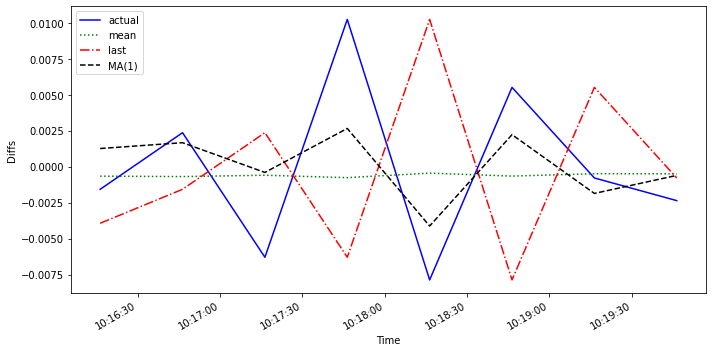

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(df['values'])
ax.plot(test['values_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_MA'], 'k--', label='MA(1)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Diffs')
#ax.axvspan(947, 998, color='#808080', alpha=0.2)
#ax.set_xlim(920, 999)
#plt.xticks([936, 988],[2018, 2019])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

¿Que modelo dio mejor? (MSE)

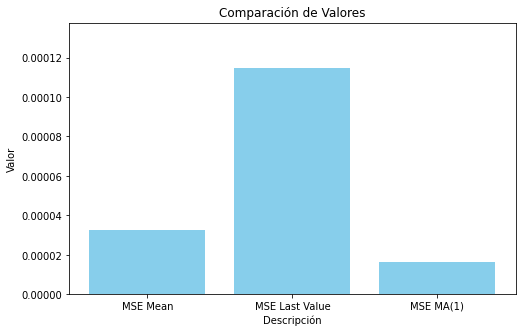

In [16]:
from sklearn.metrics import mean_squared_error
mse_mean    = mean_squared_error(test['values_diff'], test['pred_mean'])
mse_last    = mean_squared_error(test['values_diff'], test['pred_last_value'])
mse_MA      = mean_squared_error(test['values_diff'], test['pred_MA'])

df_comm = pd.DataFrame({
    'Descripción': ['MSE Mean', 'MSE Last Value', 'MSE MA(1)'],
    'Valor': [mse_mean, mse_last, mse_MA]
})

plt.figure(figsize=(8, 5))
plt.bar(df_comm['Descripción'], df_comm['Valor'], color='skyblue')

plt.title('Comparación de Valores')
plt.xlabel('Descripción')
plt.ylabel('Valor')
plt.ylim(0, max(df_comm['Valor']) * 1.2)  # margen superior
plt.show()

Volvemos a los datos originales (Aca hay un problema, claramente)

In [17]:
df_diff1.loc[test.index, ["Predicted_diffs"]] = test["pred_MA"]

In [18]:
#len(ldf["pred_MA"][len(train):])
#len(df_diff1.loc[:, channel_name][len(train)]+test['pred_MA'].cumsum())
df_diff1["Predicted_serie"] = df_diff1.loc[:, channel_name][len(train)]+test['pred_MA'].cumsum()


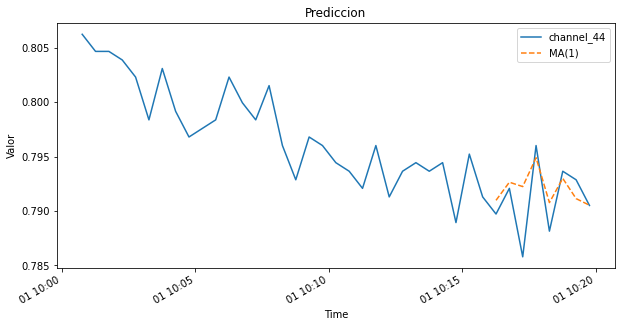

In [237]:
plt.figure(figsize=(10, 5))
plt.plot(df_diff1.index, df_diff1[channel_name], label=channel["Channel"])
plt.plot(df_diff1.index, df_diff1["Predicted_serie"], label='MA(1)', linestyle='--')
plt.title("Prediccion")
plt.xlabel("Time")      
plt.ylabel("Valor")
plt.gcf().autofmt_xdate()   
plt.legend()
plt.show()

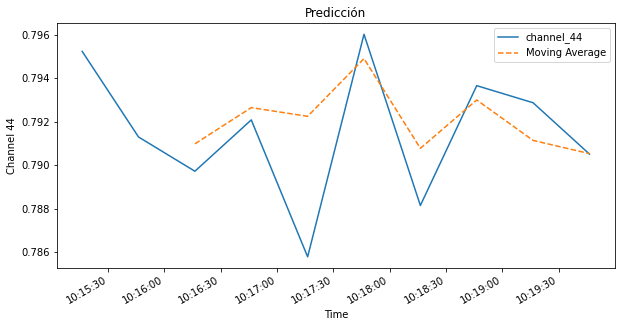

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(df_diff1.index[-10:], df_diff1[channel_name][-10:], label=channel["Channel"])
plt.plot(df_diff1.index[-10:], df_diff1["Predicted_serie"][-10:], label='Moving Average', linestyle='--')
plt.title("Predicción")
plt.xlabel("Time")      
plt.ylabel("Channel 44")
plt.gcf().autofmt_xdate()   
plt.legend()
plt.show()